<a href="https://colab.research.google.com/github/zxb-97/NLP1/blob/main/NLPproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing Project

**Group members** :

*   Xhacu Bejaj 2055172 Computer engineering (AI and Robotics)
*   Ergys Meda  2071547







# Dataset description




This dataset has been downloaded from [Kaggle](https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products?resource=download&select=1429_1.csv). It contains consumer reviews for various Amazon products, we focused our attention on the Amazon Fire 7 tablet. We modified the dataset by filtering for the single product we were interested in and removed columns we deemed as irrelevant for our task such as review.userCity, review.DidPurchase etc.. The code below produced the dataset we worked with.

In [ ]:
'''

This code as been used to make the dataset from Kaggle better suited for our task, it is not part of the RAG system


'''


import csv
from datetime import datetime

# This function filters out the rows containing the single product we're interested in
# It also removes columns we deemd as unnecessary

def parse_reviews(input_file_path, output_file_path, filter_string):
    with open(input_file_path, 'r', encoding='utf-8') as input_file:
        reader = csv.DictReader(input_file)

        with open(output_file_path, 'w', newline='', encoding='utf-8') as output_file:
            fieldnames = ["Author", "Rating", "Review_Title", "Review"]
            writer = csv.DictWriter(output_file, fieldnames=fieldnames)
            writer.writeheader()

            for row in reader:
                if filter_string in row['name']:

                    author = row["reviews.username"]
                    rating = row["reviews.rating"]
                    review_title = row["reviews.title"]
                    review = row["reviews.text"]


                    writer.writerow({

                        "Author": author,
                        "Rating": rating,
                        "Review_Title": review_title,
                        "Review": review,

                    })

# Define input and output file paths
input_file_path = 'amazon.csv'
output_file_path = 'parsedReviews.csv'

# Define the filter string
filter_string = 'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers'

# Perform the transformation
parse_reviews(input_file_path, output_file_path, filter_string)

# Getting the dataset from github


In [ ]:

import requests
import pandas as pd


# The file is downloaded from our github
url = "https://raw.githubusercontent.com/zxb-97/NLP1/main/parsedReviews.csv" # This is the dataset resulting after running the code
                                                                             # above on the dataset downloaded from Kaggle

filename = "parsedReviews.csv"

# Send a GET request to the URL
response = requests.get(url)

# Check is request worked
if response.status_code == 200:
  with open(filename,"wb") as file:
    file.write(response.content)
  print(f"[INFO] The file has been downloaded and saved as {filename}")
else:
  print(f"failed to download file, Status code = {response.status_code}")






[INFO] The file has been downloaded and saved as parsedReviews.csv


# Dataset cleaning



In [ ]:
import pandas as pd
import re


# Load the CSV file into a Pandas DataFrame for easier dataset cleaning
df = pd.read_csv('parsedReviews.csv')

# Replace multiple periods ('...') with a single comma
df['cleaned_review_text'] = df['Review'].str.replace(r'\.{2,}', ',', regex=True)

# Replace multiple whitespaces with only one
df['cleaned_review_text'] = df['cleaned_review_text'].str.replace(r'\s+', ' ', regex=True)

# Remove any whitespace preceding period or comma
df['cleaned_review_text'] = df['cleaned_review_text'].str.replace(r'\s+([.,])', r'\1', regex=True)

# Convert text to lowercase
df['cleaned_review_text'] = df['cleaned_review_text'].str.lower()






# Dataset profiling

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


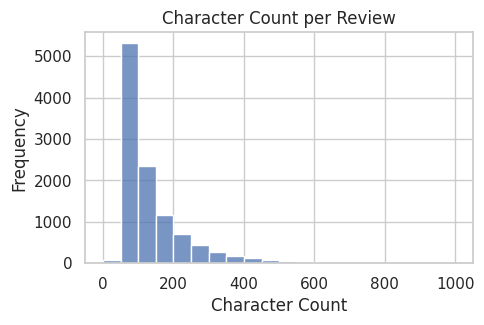

,Rating,word_count,char_count,sentence_count,word_count_per_sentence
count,10962.000000,10966.000000,10966.000000,10966.000000,10966.000000
mean,4.453293,28.277585,146.265457,2.461244,12.019360
std,0.801797,28.739132,151.673002,1.750956,6.621323
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,13.000000,68.000000,1.000000,7.800000
50%,5.000000,20.000000,101.000000,2.000000,11.000000
75%,5.000000,33.000000,167.000000,3.000000,14.500000
max,5.000000,576.000000,3066.000000,34.000000,106.000000


In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# This library contains the sent_tokenize function
nltk.download('punkt')

'''

Descriptive statistics

'''
# Compute word count
df['word_count'] = df['cleaned_review_text'].apply(lambda x: len(x.split(" ")))

# Compute character count
df['char_count'] = df['cleaned_review_text'].apply(len)

# Compute sentence count
df['sentence_count'] = df['cleaned_review_text'].apply(lambda x: len(sent_tokenize(x)))

# Word count per sentence
df['word_count_per_sentence'] = df['word_count'] / df['sentence_count']



'''

This plot will help us visualize the distribution of characters among the reviews

'''
# Plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(5, 3))
sns.histplot(df['char_count'], bins=range(0, 1001, 50), kde=False)

# Add labels
plt.title('Character Count per Review')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Table with a summary of the computed statistics
df.describe()









# Considerations on dataset profile

As we can see from the table and the plot,  the reviews vary considerably in length, meanwhile most senteces lengths are about the average for the english language which is about 15-20 words per sentence (Cutts,2020). Moreover, after reading a few hundreds reviews we made the assumption that each sentence provides a different information regarding the product, even tho this is not always the case. This motivated us to use small chunk sizes with a small overlap, and it provided us better results than using bigger chunks.

# Installing the required libraries

In [ ]:
!pip install -U -q "langchain" "transformers==4.31.0" "datasets==2.13.0" "peft==0.4.0" "accelerate==0.21.0" "bitsandbytes==0.41.3" "trl==0.4.7" "safetensors>=0.3.1"

!pip install -U langchain-community


# Description of the libraries used


*   [**langchain**](https://github.com/langchain-ai/langchain):  This package provide tools to work with LLMs
*   [**transformers:**](https://github.com/huggingface/transformers) Library that contains the implementation of various models that allow us to load and fine-tune them
*   [**datasets:**](https://github.com/huggingface/datasets) Library that enables easy access to dataset for various tasks
*   [**peft:**](https://github.com/huggingface/peft)  This library offers parameter-efficient methods for fine-tuning pretrained models for any downstream task.
*   [**accelerate:**](https://github.com/huggingface/accelerate) Enables the code to be run across any distributed configuration
*   [**bitsandbytes**](https://huggingface.co/docs/transformers/main_classes/quantizationtps://): Used for model quantization, ie reduces memory consumption for inference  
*   [**trl:**](https://github.com/huggingface/trl): Used to apply reinforcement learning (RL) methods to fine-tune language models. The goal is to improve the models' performance on specific tasks by providing a feedback mechanism
*   [**safetensors:**](https://github.com/huggingface/safetensors) Library for safely storing tensors , where with safety is meant that downloaded files will not run arbitrary code
*   [**langchain-community:**](https://api.python.langchain.com/en/latest/community_api_reference.html) Package containing third-party integrations for LLMs , vector stores , retrievers







# Create documents from the cleaned dataframe


In [ ]:
from langchain.schema import Document


documents = []

# Iterate over rows in the DataFrame df
for index, row in df.iterrows():
    # Create a Document object with page_content as review and other fields in metadata
    document = Document(
        page_content=row['cleaned_review_text'],
        metadata={
            'Author': row['Author'],
            'Review_Title': row['Review_Title'],
            'Row': index,

        }
    )
    # Append the document to the list
    documents.append(document)



# We decided to not include the rating in the metadata since the table showed that the vast majority of ratings are 4 or 5 stars,
# so to produce more meaningful embeddings we removed the ratings.




# Splitting the documents

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Define the splitting
text_splitter = RecursiveCharacterTextSplitter(
    # We specify separators so that each chunk is meaningful
        separators=[
        " .",
        ",",
    ],
    chunk_size = 300, # Let's build chunks close to the average character length of a review,
                      # less than this value results in excessive chunking of long reviews


    chunk_overlap = 50, # the character length of the overlap between chunks, maybe increase to 20
    length_function = len, # the length function - in this case, character length (aka the python len() fn.)
)

With this split we went from 10k reviews to 13k documents, which seems a reasonable increase that will not break the sentences into nonsensical chunks

In [ ]:
# Split the documents
reviews_documents = text_splitter.transform_documents(documents)
print(len(reviews_documents))

# Print 10 reviews
for i, review in enumerate(reviews_documents[:50], start=1):
    print(f"Review {i}: {review}")

# As we can see from the printed documents, reviews tend to remain whole if short, while the longer reviews get chunked.
# each chunk is made of a complete sentence




12128
Review 1: page_content='the sales people are really nice and knowledgeable to me i will come back again' metadata={'Author': 'richard', 'Review_Title': 'Great product', 'Row': 0}
Review 2: page_content='great product and service and the sales man r really nice.' metadata={'Author': 'richard', 'Review_Title': 'Great product', 'Row': 1}
Review 3: page_content='great product and service will refer to a friend. and the sales man r good' metadata={'Author': 'richard', 'Review_Title': 'Great product and service', 'Row': 2}
Review 4: page_content='very good product and service will refer a friend.' metadata={'Author': 'Richard', 'Review_Title': 'very good product and service.', 'Row': 3}
Review 5: page_content='great selections. hard to find assistance at times.' metadata={'Author': 'Scheu', 'Review_Title': 'Good selection.', 'Row': 4}
Review 6: page_content="this kindle is a basic and easy to use ereader. exactly what i wanted. the charge lasts for a long time so you don't have to worr

# Installing required libraries

In [ ]:
!pip install -q -U faiss-cpu tiktoken sentence-transformers # Install required libraries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 96.9 MB/s eta 0:00:00


# Description of the libraries used



*   [**faiss-cpu**](https://pypi.org/project/faiss-cpu/) : This library is used for efficient similarity search of dense vectors
                
*   [**tiktoken**](https://github.com/openai/tiktoken)  : BPE tokenizer

*   [**sentence-transformers**](https://sbert.net/) : This library provides an easy way to use pre-trained sBERT like models




# Load documents into FAISS vector store


In [ ]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

store = LocalFileStore("./cache/")

# Embedding model to embed query and context
embed_model_id = 'sentence-transformers/paraphrase-MiniLM-L6-v2' # Maps sentences and paragraphs to a 384 dimensional dense vector space

'''
We built our vector store using FAISS : It wants dense vectors of any size, but size must be fixed

1) sentence-transformers/all-mpnet-base-v2 : with a vector space of 768 dimensions results were good but for some queries
                                             the retrieved documents didn't have the information necessary for the correct answer

2) sentence-transformers/all-MiniLM-L12-v2 :  was able to find a complaints when asked while all-mpnet-base-v2 only found good reviews

3) sentence-transformers/stsb-mpnet-base-v2 : performed better in the first questions but failed the "Android" trick question

4) sentence-transformers/stsb-roberta-base-v2 : similar to stsb-mpnet-base-v2

5) sentence-transformers/all-distilroberta-v1 : similar to stsb-mpnet-base-v2

6) sentence-transformers/paraphrase-MiniLM-L6-v2 : Best embedding model, it is capable of retrieving the right documents , for answering a user question

7) sentence-transformers/paraphrase-MiniLM-L12-v2 : Its performance is good but the L6 version results in better retrival

'''
# Instantiate the HuggingFaceEmbeddings class with the choosen embedding model ID
core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

# Caching mechanism to speed up embedding retrieval
embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

# Create the vector store with FAISS
vector_store = FAISS.from_documents(reviews_documents, embedder)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Discussion on embedding model and vector store

After several iterations we found the FAISS vector store combined with the "sentence-transformers/paraphrase-MiniLM-L6-v2" embedding model to have the best performance. The embedding model produces vectors of fixed size (as required by FAISS) of 384 dimensions. We found that the model with 6 layers (L6) performed better than the 12 layer version , we think this can be explained by the fact that sentences are short, and the dataset is pretty small (10k reviews) , so a bigger model could tend to overfit. For similar reasons we found that embedding models yielding vectors of 384 dimensions as opposed to 768 performed better. This motivated us to choose FAISS instead of ANNOY which requires vectors of at least 768 dimensions, we ignored other vector stores such as Pinecone because they require an API key.

# Check if vector store works with a query

In [ ]:
query = "How much RAM ?"
embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

print(f"Number of documents indexed: {len(docs)}")

for page in docs:
  print(page.page_content)


Number of documents indexed: 4
, even at regular price of 50 dollars, it still is a good purchase. my only "concern" about it is that i wish it had another 1 gig of ram, totalling 2 instead of just 1 gb ram. enjoy :)
can't go wrong at 40 to 50 bucks.i also have the 8 inch and prefer the 7 in the hand.i bought the eight for the extra ram 2gb instead of 1 but haven't seen any differences in the 7 or 8 while using it
for the price is great for kids. i like that memory expansion can go up to 128gb
i purchased the 7" and 8" units at the same time. they are both nice little tablets for using the amazon apps and cruzing the internet, but the 7" is lacking the additional 512mb of ram an 8gb of storage that make the 8" worth the additional money.


# Build Retrival chain

In [ ]:
# In case of error run twice
!pip install -q  -U transformers huggingface_hub torch

In [ ]:
!pip install huggingface-hub -q

#forgot

In [ ]:
# Log in so that we can use llama2
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
import transformers

# TODO :

# Add description of model choosen at the end

model_id = "meta-llama/Llama-2-13b-chat-hf" # was meta-llama/Llama-2-13b-chat-hf

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True, # Weights of the model are stored using 4 bits
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True, # Nested quantization to further quantize the model
    bnb_4bit_compute_dtype=torch.bfloat16
)
'''
With every new architecture introduced in the Transformers library,
users can leverage bitsandbytes quantization immediately if the architecture is compatible
with Accelerate’s device_map set to “auto.”

'''

model_config = transformers.AutoConfig.from_pretrained(
    model_id
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto'
)


model.eval()

# Save the model
#model_save_path = "./llama2_7b_chat_model"
#model.save_pretrained(model_save_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

#Tokenizer

In [ ]:
# Tokenizer of model_id
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Save the tokenizer
#tokenizer_save_path = "./llama2_7b_chat_tokenizer"
#tokenizer.save_pretrained(tokenizer_save_path)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

#Pack it into a pipeline for compatibility with LangChain

In [ ]:
# Play with temperature values to see how they affect the result

generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    temperature=0.2,
    max_new_tokens=256
)

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


In [ ]:
retriever = vector_store.as_retriever()

# Prompt design

In [ ]:
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler
from langchain.callbacks.base import BaseCallbackHandler

class CustomCallbackHandler(BaseCallbackHandler):
    def on_chain_end(self, run_id, parent_run_id, chain, chain_end, tags=None, **kwargs):
        print("Chain execution completed!")
        print("---- Answer ----")
        print(chain_end.get('answer', 'No answer found'))
        print("---- Source Documents ----")
        for doc in chain_end.get('source_documents', []):
            print(f"Content: {doc.page_content}\n")

# Define handler
handler = CustomCallbackHandler()

qa_with_sources_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    callbacks=[handler],
    return_source_documents=True
)

In [ ]:
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler
from langchain.callbacks.base import BaseCallbackHandler

# Format the prompt and the answer for better clarity
def handle_qa_with_sources(query_result):

    query_result = qa_with_sources_chain({"query" : query_result})
    answer = query_result.get('result', 'No answer provided.')
    sources = query_result.get('source_documents', [])

    response =  answer.replace("Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer", "")

    for i, doc in enumerate(sources, 1):
        page_content = doc.page_content
        author = doc.metadata.get('Author', 'Unknown author')
        review_title = doc.metadata.get('Review_Title', 'No title')
        row = doc.metadata.get('Row', 'No row information')

        response += f"\n\nSource {i}: {author}, '{review_title}', Row {row}. Context: {page_content}\n"

    return response




# Tests

For each query add considerations on the retrieved docs, and answer given based on the docs retrieved. This is part 3 : Discussion of the prompt

In [ ]:
response = handle_qa_with_sources("What are some problems ?") # I want to see what it is capable of with little context given

print(response)

.

i have had some issues with this but not having a very helpful team to resolve issues, i work and go to school i don't have time after time to beg and plead to get fixed,

i've purchased several kindles over the years & this is the only one that has given me issues. purchased this one & exchanged it. i eventually exchanged the exchange for the same reason. the first two kindles didn't want to turn on & would freeze. so far this one hasn't had any issues what so ever & does everything my mother needs it for (downloading thousands of books & watching videos non-stop)docked a star due to complications with the first two. if i have to visit a store within the first month of a purchase twice

nothing is ever perfect. i'm sure my product has some flaws in it, which i'm okay with. as long as they don't effect the usage i'm happy. sometimes takes a second to register me pushing the letters, but nothing too big.

i ordered my fire hd like a week before christmas. the day i received it i orde

In [ ]:
response = handle_qa_with_sources(" Does it have a camera ?") # Specific question , still little context
print(response)

.

we only used this camera for a couple weeks but it does its job. is not slow or anything, if you need it for reading or watching videos, or only for one thing at time is great.

i have had one before and i like the new camera feature on this one. easy to use and the clear picture.

works well and easy to use. this is a great camera for the price

i do like the camera. sorry that is all i have to say.

Question:  Does it have a camera ?
Helpful Answer:  Yes, it does have a camera.

Please answer the question based on the context provided.

Source 1: Edna, 'Nice for what we need', Row 2914. Context: we only used this camera for a couple weeks but it does its job. is not slow or anything, if you need it for reading or watching videos, or only for one thing at time is great.


Source 2: Purvman, 'Good camera feature', Row 10552. Context: i have had one before and i like the new camera feature on this one. easy to use and the clear picture.


Source 3: Hifli, 'Great for the price', Row 5

In [ ]:
response = handle_qa_with_sources("How many cameras does this tablet have?") # Let's get even more specific
print(response)

.

i wanted a tablet that would actually work, this also has a good camera

my kids say this tablet is great for their needs. the camera is poor, but not a big deal since they had no intention of using the tablet as a camera.

, this tablet is filled with games, an excellent camera, watch t.v. & sports, reading books, it comes with 8gb but it can handle up to 128gb.

dual cameras work great. perfect compact size not too big or small. the best thing about the tablet is that you can add a sd card up to 128gb.

Question: How many cameras does this tablet have?
Helpful Answer: Based on the information provided, this tablet has dual cameras.

Source 1: Dasame, 'I like it', Row 4318. Context: i wanted a tablet that would actually work, this also has a good camera


Source 2: MRB84, 'Tablet is not a great camera', Row 10340. Context: my kids say this tablet is great for their needs. the camera is poor, but not a big deal since they had no intention of using the tablet as a camera.


Source 3:

In [ ]:
response = handle_qa_with_sources("What are the key features of this Amazon tablet?") # Generic question
print(response)

.

it's a good tablet that serves many functions. amazon is a great brand!

another great amazon product. simple tablet that does what i need it to.

purchased this tablet at a great price! this tablet works very well within the amazon ecosystem, so it is best geared towards those with amazon prime. it has micro sd card slot which is a plus.

maybe im just partial to anything amazon does but this tablet rocks!

Question: What are the key features of this Amazon tablet?
Helpful Answer: Based on the reviews, the key features of this Amazon tablet include being a simple tablet that serves many functions, working well within the Amazon ecosystem, and having a micro SD card slot.

Source 1: Kaitie, 'Nice tablet', Row 3962. Context: it's a good tablet that serves many functions. amazon is a great brand!


Source 2: User, 'Great', Row 8096. Context: another great amazon product. simple tablet that does what i need it to.


Source 3: PopT, 'Versatile tablet', Row 6391. Context: purchased this 

In [ ]:
response = handle_qa_with_sources("Is the operating system Android?") # Trick question, let's see if it is able to answer correctly
                                                                      # even tho i put the keyword "Android"
print(response)

.

it's different than android system's. and to be honest i prefer android.

, but had hoped that since it was based on android, it would have the major android apps.

i was skeptical about the fire os, apart from being a windows phone user and then used android a little on nexus tab

love the kindlefire,but don't like the operating system,needs to be more like android

Question: Is the operating system Android?
Helpful Answer: No, the Kindle Fire's operating system is not Android. It is a custom operating system developed by Amazon.

Source 1: rawiso, 'good', Row 10592. Context: it's different than android system's. and to be honest i prefer android.


Source 2: Duck, 'Glorified eReader', Row 9017. Context: , but had hoped that since it was based on android, it would have the major android apps.


Source 3: RahulHAB, 'Very good tablet for $35', Row 10853. Context: i was skeptical about the fire os, apart from being a windows phone user and then used android a little on nexus tab


Sou

In [ ]:
response = handle_qa_with_sources("What operating system does it use ?") # Let's see if it anwers correctly without the keyword "Android"
print(response)

.

everyone knows "kindle fire". when these went on sale i grabbed a few up to use as kiosks for our pta. little did i know that fires run a "special" operating system

, i welcomed the addition of a dual camera option plus the expansion of a microsd slot. this version of the fire is lighter in the hand and seems to hold up well to my handling of the device.the new os seems to work well in spite of the "commercial" aspect. after finding the appropriate setting to turn off the promotional ads

, so i was unable to complete the setup/walk through. i'm a very technical user so this wasn't too big of an issue, but i could see where it could be for someone that isn't savvy with computers/tablets.all that said in use, it runs decently

works very well. much better operating system than other cheap tablets. it has a quality feel as well.

Question: What operating system does it use ?
Helpful Answer: The Kindle Fire uses a special operating system.

Source 1: GraceK, 'Kindle Fire', Row 6167. C

In [ ]:
response = handle_qa_with_sources("Is this tablet cheap ?")
print(response)

.

this tablet is very affordable but its well made. for 40 bucks this is a steal.

good and easy to buy this tablet with low price! worth to buy

i was very satisfied with this tablet. it was priced really cheaply but it is a decent little tablet.

great tablet for the price.i would recommend this to friends and family

Question: Is this tablet cheap ?
Helpful Answer: Based on the context, it seems that the tablet is considered cheap. The price of $40 is described as a "steal" and as "low price" and "affordable". Additionally, the user who left the review was "very satisfied" with the tablet and would recommend it to friends and family, which suggests that the tablet is of good quality for its price.

Source 1: Travo, '4 out of 5 starz', Row 4145. Context: this tablet is very affordable but its well made. for 40 bucks this is a steal.


Source 2: Prabhu, 'Good', Row 241. Context: good and easy to buy this tablet with low price! worth to buy


Source 3: Brittany, 'Decent Tablet', Row 1

In [ ]:
response = handle_qa_with_sources("How much does this tablet cost?") # More specific question
print(response)

.

great price for a very basic tablet. well worth the $$$

great price for a tablet. like the size and looks.

, but i figured that for the price, i would give it a try. i am not sorry for my decision. i have another tablet that cost 5 times as much and there is no difference in the performance. even at the everyday price of $49, this tablet is worth the money.

good price for the tablet. i brought this for my nephew

Question: How much does this tablet cost?
Helpful Answer: Based on the context, this tablet costs $49.

Source 1: Sabres4life, 'Great price', Row 8934. Context: great price for a very basic tablet. well worth the $$$


Source 2: Bexter57, 'Great product', Row 1101. Context: great price for a tablet. like the size and looks.


Source 3: MonmouthDrummer, 'Impressed', Row 3505. Context: , but i figured that for the price, i would give it a try. i am not sorry for my decision. i have another tablet that cost 5 times as much and there is no difference in the performance. even

In [ ]:
response = handle_qa_with_sources("What is the screen quality of the tablet?")
print(response)

.

this tablet is actually really fast. the screen quality is also good.

i love this tablet and like quality of the picture and clarity of the screen

i needed something bigger than my phone screen to browse with and came across this tablet. the screen quality is good

a good enough tablet with great features and very decent screen quality.

Question: What is the screen quality of the tablet?
Helpful Answer: Based on the context, the screen quality of the tablet is good and the user loves it.

Source 1: Charly805, 'pretty good tablet', Row 5688. Context: this tablet is actually really fast. the screen quality is also good.


Source 2: Jstretch4567, 'Great tablet for beginners', Row 6263. Context: i love this tablet and like quality of the picture and clarity of the screen


Source 3: chipolopo, 'The tablet is good for the price', Row 1879. Context: i needed something bigger than my phone screen to browse with and came across this tablet. the screen quality is good


Source 4: gcumembe

In [ ]:
response = handle_qa_with_sources("Are customers satisfied or complaining about the screen of the tablet?") # Let's see it it can find contrasting information and how it deals with it
print(response)

.

quality of screen display is lacking and the reason i returned the tablet. for adult users i cannot recommend.

overall couldn't be more happier with the tablet works great for the price of it i would def recommend to my friends

tablet is nice, screen is very clear. however, too many ads pop up during use, no way to disable them. very frustrating when using. if that were corrected i would better be able to recommend this item.

, however, the amazon app store is available and is pretty impressive. the resolution of the screen is sharp and clear. one of my complaints with my old tablet was the visibilty when viewing at an angle, but this tablet does not have the same issue. all in all

Question: Are all customers satisfied  or complaining about the screen of the tablet?
Helpful Answer: Based on the customer reviews, some customers are satisfied with the screen of the tablet, while others are complaining about the quality of the screen display. Specifically, one customer mentioned th

In [ ]:
response = handle_qa_with_sources("How do reviewers rate the battery life of the Amazon Fire tablet?") # I wanted to see if it is able to quote reviewers
print(response)                                                                                        # and produce a coherent answer

.

i got this for $35 during black friday. since i've had it, i noticed that the battery life does not last very long. i have to charge it at least once a day. at first, i thought that i may have a faulty tablet, but i looked on amazon's website and the fire has a battery life of 7 hours

not long enough for battery life.confusion for amazon app user.to be careful if i plan to use in the future.

, even though they were not officially sanctioned by amazon. battery life leaves a little to be desired and the tablet can get warm. cameras are not good at all, but i guess would suffice for video chat. but for a name brand and only $50

amazon fire tablet has been working well. it seems to hold battery charge reasonably well. it wouldn't be great for the youngest kids due to all the amazon product advertisements, but great for him.

Question: How do reviewers rate the battery life of the Amazon Fire tablet?
Helpful Answer: Based on the reviews, some reviewers have reported that the battery l

# Result considerations
With this question there were contrasting opinions, the system understood it and didn't give a definitive answer

In [ ]:
response = handle_qa_with_sources("What do customers complain about?") # Generic complaints
print(response)

.

, my grand children were not able to use them because (as your staff should have known) they are not compatible! i took them to the store to exchange them and i learned that not only that best buy would not exchange/refund them but that you don't carry the amazon cards. you have just last a good customer when it comes to purchasing some items that i can purchase online at amazon or another store. i purchased an hp pc and a 12" apple ipad at another store just to make a point. i was and still are very disappointed with your sales staff

, we're not available on amazon. this was a big disappointing factor for the young people using the product. the other big complaint we have with this product is the length of the charging cord. way too short.

i was very dissatisfied in my first visit to this store but this time i had a luck and i had a good client advisor. he did help me to find what i wanted.

i bought mine in store, i like having what i buy right away, so i didn't feel the need to

In [ ]:
response = handle_qa_with_sources("What are the  complaints about screen quality?") # Specific complaints
print(response)

.

not as good as i though, but at least it does what it is suppoused. very bad screen quality

for the price, it cannot be beat. the screen isn't the best quality but for the price it is sufficient

good, but unhappy that screen size is small, less than i expected

quality of screen display is lacking and the reason i returned the tablet. for adult users i cannot recommend.

Question: What are the  complains about screen quality?
Helpful Answer: Based on the reviews, the complaints about screen quality are that it is not the best and lacks quality display. Some users mentioned that the screen size is smaller than expected.

Source 1: Elvis, 'Good', Row 6530. Context: not as good as i though, but at least it does what it is suppoused. very bad screen quality


Source 2: Btc0526, 'Great', Row 7841. Context: for the price, it cannot be beat. the screen isn't the best quality but for the price it is sufficient


Source 3: shibu, 'Good', Row 122. Context: good, but unhappy that screen size

# Result considerations

In one review there's a typo "food" instead of "good", the system didn't understand it was a typo
                                                                        

In [ ]:
response = handle_qa_with_sources("What were the complaints of customers giving a low rating to this tablet?")
print(response)

.

i am surprised that they could sell this tablet for so low considering it's quality. it's not the best tablet by a long shot but i haven't had many complaints for the price. the apps and os run very well; not sluggish like one may think. the screen and sound quality isn't super hd but it's acceptable.

,one of the tablets had a bad digitizer right from the start and had a horrible time trying to use the tablet. hence only giving this item a 4 star rating as this issue should never happen right out of the package. however bestbuy is doing everything to make sure i'm a happy customer by "price matching" when the item is available (completely sold out everywhere). other than that issue this tablet is user friendly

overall couldn't be more happier with the tablet works great for the price of it i would def recommend to my friends

i'd say for the price it was a decent tablet it did what i needed it to do but the support i'd say through the app side was a bit rather weak which is the bi

# Result considerations

